In [1]:
import torch
from torch.nn.functional import pad
from torch.utils.data import DataLoader, Dataset

In [2]:
from tqdm.notebook import tqdm

In [3]:
from models.model import CustomModelNoDownsize as CustomModel
from models.model import CRFModelV2 as CRFModel

In [4]:
from datasets import load_from_disk

In [5]:
import tokenmonster

In [6]:
tokenizer_file = "english-8000-balanced-v1"

In [7]:
vocab = tokenmonster.load_multiprocess_safe(tokenizer_file)

In [8]:
initial_vocab_size = len(vocab)

In [9]:
# initial_vocab_size is 8000, so largest valid index is 7999

In [10]:
pad_idx = initial_vocab_size # max valid index is now 8000
eos_idx = initial_vocab_size + 1 # max valid index is now 8001

In [11]:
vocab_size = initial_vocab_size + 2

In [12]:
question_len = 256
context_len = 512
answer_len = 100
assert context_len >= answer_len

In [13]:
embedding_dim = 512
num_heads = 8
num_helix_layers = 1
num_single_strand_layers = 1
phm_factor = 4
lm_head_phm_factor = 2
beam = 32
low_rank = 16
batch_size = 1
gradient_accumulation_steps = 52
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [14]:
print(f"Using device: {device}")

Using device: cuda


In [15]:
checkpoint_dir = "checkpoints"

In [16]:
path = f"{checkpoint_dir}/crf_model_test.pt"

In [17]:
squad_train_file = "data/squad_train"
dolly_test_file = "data/closed"

In [18]:
squad = load_from_disk(squad_train_file)
dolly = load_from_disk(dolly_test_file)

In [19]:
def collate_fn(batch, question_key, context_key, answer_key):
    """
    Each batch has 3 elements: instruction, context, response
    However since their lengths may vary, we need to pad them.

    For response, must ensure that we add eos token and then begin padding.
    """
    contexts = []
    answers = []

    for elem in batch:
        i = elem[question_key]
        c = elem[context_key]
        r = elem[answer_key]

        c = torch.cat((i, c))
        contexts.append(c)
        answers.append(r)


    # Pad contexts to context_len
    contexts = [pad(c, (0, (context_len+question_len) - len(c)), value=pad_idx) for c in contexts]

    # Pad responses to answer_len
    # though first making sure that eos token is added to end of each response
    eos_append = torch.tensor([eos_idx])
    answers = [torch.cat((r[:answer_len-1], eos_append)) for r in answers]
    answers = [pad(r, (0, answer_len - len(r)), value=pad_idx) for r in answers]

    return torch.stack(contexts), torch.stack(answers)

In [20]:
def dolly_collate_fn(batch):
    return collate_fn(batch, "instruction", "context", "response")

In [21]:
def squad_collate_fn(batch):
    return collate_fn(batch, "question", "context", "answers")

In [22]:
dollyDataloader = DataLoader(dolly, batch_size=batch_size, shuffle=True)

In [23]:
squadDataloader = DataLoader(squad, batch_size=batch_size, shuffle=True)

In [24]:
from torch.optim import Adam
import datetime
import os

In [25]:
def save_checkpoint(losses, model, crf, optm, tensorboard_log_dir):
    # first check to see if checkpoint dir exists, if not, create it
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)
    torch.save({
    'epoch': len(losses),
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optm.state_dict(),
    'loss': losses[-1],
    'losses': losses,
    'crf_state_dict': crf.state_dict(),
    'model_kwargs': model.kwargs,
    'crf_kwargs': crf.kwargs,
    'tensorboard_log_dir': tensorboard_log_dir
    }, path)
def load_checkpoint(map_location=None):
    checkpoint = torch.load(path, map_location=map_location)
    model = CustomModel(**checkpoint['model_kwargs'])
    crf = CRFModel(model=model, **checkpoint['crf_kwargs'])
    model.load_state_dict(checkpoint['model_state_dict'])
    crf.load_state_dict(checkpoint['crf_state_dict'])
    model = model.to(device)
    crf = crf.to(device)
    optm = torch.optim.Adam(crf.parameters())
    optm.load_state_dict(checkpoint['optimizer_state_dict'])
    losses = checkpoint['losses']
    log_dir = checkpoint['tensorboard_log_dir']
    return losses, model, crf, optm, log_dir
def try_loading():
    """
    First try to load the model, if it doesn't exist, create one
    based on the parameters specified above
    """
    try:
        losses, model, crf, optm, log_dir = load_checkpoint()
        print(f"Resuming, have seen {len(losses)} epochs")
        print(f"Have {sum(p.numel() for p in crf.parameters() if p.requires_grad)} trainable parameters")
        print(f"Logging to {log_dir}")
        return losses, model, crf, optm, log_dir
    except FileNotFoundError:
        # couldn't find model, probably because it doesn't exist
        print("Couldn't find model, creating new one")
        model = CustomModel(embedding_dim, num_heads, vocab_size, num_helix_layers=num_helix_layers, num_single_strand_layers=num_single_strand_layers, phm_factor=phm_factor, lm_head_phm_factor=lm_head_phm_factor)
        model = model.to(device)
        crf = CRFModel(model, vocab_size, beam, low_rank, pad_idx)
        crf = crf.to(device)
        optm = Adam(crf.parameters(), lr=0.001)
        losses = []
        print(f"Have {sum(p.numel() for p in crf.parameters() if p.requires_grad)} trainable parameters")
        # create a string to identify this model for tensorboard logging
        now = datetime.datetime.now()
        log_dir = f"runs/run_at_{now.strftime('%Y-%m-%d_%H-%M-%S')}"
        print(f"Logging to {log_dir}")
        return losses, model, crf, optm, log_dir
    except RuntimeError:
        # probably because model was saved on gpu and now we're using cpu
        # so can still load it, but need to specify map_location
        print("Model found but was saved on gpu, attempting to load on cpu")
        losses, model, crf, optm, log_dir = load_checkpoint(map_location='cpu')
        print(f"Resuming, have seen {len(losses)} epochs")
        print(f"Have {sum(p.numel() for p in crf.parameters() if p.requires_grad)} trainable parameters")
        print(f"Logging to {log_dir}")
        return losses, model, crf, optm, log_dir

In [26]:
from loss_functions.unlikelihood_loss import unlikelihood_loss
from loss_functions.nag_bert_loss import nag_bert_loss

In [27]:
k = 3
nll_loss_weight = 0.5

In [28]:
losses, model, crf, optm, log_dir = try_loading()

Couldn't find model, creating new one
Have 10783810 trainable parameters
Logging to runs/run_at_2023-11-25_11-54-12


In [29]:
def custom_loss(logits, targets, crf_losses):
    cross_entropy_loss = torch.nn.functional.cross_entropy(logits.reshape(-1, vocab_size), targets.view(-1), ignore_index=pad_idx, reduction='none').view(batch_size, answer_len)
    target_padding_matrix = ~targets.eq(pad_idx)
    target_padding_matrix = target_padding_matrix.type(cross_entropy_loss.type())
    cross_entropy_loss = cross_entropy_loss * target_padding_matrix
    summed_loss = cross_entropy_loss.sum(dim = -1)
    one_step_train_loss = crf_losses + nll_loss_weight * summed_loss
    scaled_train_loss = torch.sum(one_step_train_loss) / torch.sum(target_padding_matrix)
    return scaled_train_loss

In [30]:
def inference(c_sample,r_sample):
    with torch.no_grad():
        model_input_sample = torch.full_like(r_sample, pad_idx)
        scores, tokens = crf.inference(c_sample, model_input_sample)
    return tokens

In [31]:
def special_decode(tokens):
    # differs from vocab.decode in that it stops decoding when it sees eos_idx or pad_idx
    filtered_tokens = []
    for t in tokens:
        if t == eos_idx or t == pad_idx:
            break
        else:
            filtered_tokens.append(t)
    return vocab.decode(filtered_tokens)

In [32]:
# import adam optimizer
from torch.optim import Adam
optm = Adam(crf.parameters(), lr=0.001)

In [33]:
cs = []
rs = []
squadIter = iter(squadDataloader)
for step in range(gradient_accumulation_steps):
    e = next(squadIter)
    c = torch.cat((e["question"].squeeze(0), e["context"].squeeze(0)))
    eos_append = torch.tensor([eos_idx])
    r = e["answers"].squeeze(0)
    r = torch.cat((r[:answer_len-1], eos_append))
    r = pad(r, (0, answer_len - len(r)), value=pad_idx)
    cs.append(c)
    rs.append(r)

In [34]:
epochs = 150

In [35]:
pbar = tqdm(range(epochs))
for epoch in pbar:
    optm.zero_grad()
    accumulated_loss = 0
    for step in range(gradient_accumulation_steps):
        c = cs[step]
        r = rs[step]
        c = c.unsqueeze(0)
        r = r.unsqueeze(0)
        c = c.to(device)
        r = r.to(device)
        model_input = torch.full_like(r, pad_idx)
        logits, crf_losses = crf(c, model_input, r)
        loss = custom_loss(logits, r, crf_losses)
        loss.backward()
        with torch.no_grad():
            accumulated_loss += loss.item()
    optm.step()
    accumulated_loss /= gradient_accumulation_steps
    losses.append(accumulated_loss)
    pbar.set_description(f"Loss: {accumulated_loss}")

  0%|          | 0/150 [00:00<?, ?it/s]

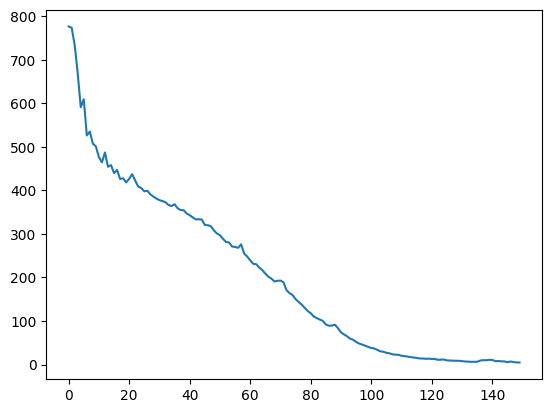

In [50]:
from matplotlib import pyplot as plt
plt.plot(losses)

In [51]:
# take sample of c and r to test model generation
sample_i = 9
assert sample_i < len(cs)
c_sample = cs[sample_i].unsqueeze(0)
r_sample = rs[sample_i].unsqueeze(0)

In [52]:
c_sample = c_sample.to(device)
r_sample = r_sample.to(device)

In [53]:
tokens = inference(c_sample,r_sample).tolist()[0]

In [54]:
tokens

[332,
 702,
 37,
 6000,
 36,
 6187,
 438,
 49,
 8001,
 438,
 49,
 8001,
 833,
 1781,
 1781,
 5655,
 63,
 8001,
 2616,
 8001,
 1730,
 1781,
 5655,
 63,
 8001,
 2616,
 8001,
 1156,
 8001,
 2616,
 8001,
 2616,
 8001,
 1156,
 8001,
 2616,
 8001,
 2616,
 8001,
 2616,
 8001,
 2616,
 8001,
 2616,
 8001,
 2616,
 8001,
 2616,
 8001,
 2616,
 8001,
 2616,
 8001,
 2616,
 8001,
 2616,
 8001,
 2616,
 8001,
 2616,
 8001,
 2616,
 8001,
 2616,
 8001,
 2616,
 8001,
 2616,
 8001,
 2616,
 8001,
 2616,
 8001,
 2227,
 1730,
 2602,
 8001,
 2227,
 582,
 53,
 8001,
 1136,
 8001,
 2227,
 1136,
 8001,
 2227,
 1730,
 3805,
 3541,
 2092,
 294,
 3791,
 1046,
 4423,
 5655,
 7757,
 645,
 388,
 7776]

In [41]:
vocab.decode(c_sample.tolist()[0])

"What did Napoleon III and the royal couple visit? Napoleon III, since the Crimean War Britain's closest ally, visited London in April 1855, and from 17 to 28 August the same year Victoria and Albert returned the visit. Napoleon III met the couple at Dunkirk and accompanied them to Paris. They visited the Exposition Universelle (a successor to Albert's 1851 brainchild the Great Exhibition) and Napoleon I's tomb at Les Invalides (to which his remains had only been returned in 1840), and were guests of honour at a 1,200-guest ball at the Palace of Versailles."

In [42]:
special_decode(tokens)

'Exposition Universelle'

In [43]:
vocab.decode(r_sample.tolist()[0])

'Exposition Universelle'

In [60]:
custom_input = "What did Napoleon III and the royal couple visit? Napoleon III, since the Crimean War Britain's closest ally, visited London in April 1855, and from 17 to 28 August the same year Victoria and Albert returned the visit. Napoleon III met the couple at Dunkirk and accompanied them to Paris. They visited the Exposition Universelle (a successor to Albert's 1851 brainchild the Great Exhibition) and Napoleon I's tomb at Les Invalides (to which his remains had only been returned in 1840), and were guests of honour at a 1,200-guest ball at the Palace of Versailles."

In [61]:
encoded = vocab.tokenize(custom_input)

In [62]:
encoded

array([ 332, 2777, 1389, 1957,   37, 1664,   49,  468, 2009,   53, 4757,
        791,  531,   56, 3978, 3636,  331,  761,   37, 1664,   49,  468,
       2009,   53,   15, 6718,   36, 1364,   37, 2521, 2900,   36, 1324,
       2114,  275, 3137,  504,    3, 2031,   15, 3636,  380, 5519,  727,
       4607,  604,   24,   24, 2821, 2373,  603,  815,  615, 5497, 6150,
       2796, 6889, 1263, 1925, 2038, 6059, 1788, 3636,  300,  761,   37,
       1664,   49,  468, 2009,   53, 1592, 1788, 3978,  655,   36,  231,
         37,  821,  429,  487, 1263,  644,   37, 1356,   37, 1644, 1042,
       5342, 4631, 4594, 3636, 3786,   36,  702,   37, 6000,   36, 6187,
        438,   49, 2165, 5310,  470,  815, 1925, 2038,  275,  604,   24,
         20, 3101,   37, 3128, 1788, 4616,   36, 7063, 2816, 1957,   37,
       1664,   49,  468,  915,  275, 1797,   46,  655,   36, 1562,   36,
        727,   37, 3632,  388,  586, 6175, 1505, 5243, 1490, 2565, 2222,
       6059,  727,  604,   23,   19, 3685, 2775, 32

In [63]:
# encoded from uint16 to int32
encoded = encoded.astype('int32')

In [64]:
encoded = torch.tensor(encoded).unsqueeze(0)

In [65]:
encoded.shape

torch.Size([1, 172])

In [71]:
encoded

tensor([[ 332, 2777, 1389, 1957,   37, 1664,   49,  468, 2009,   53, 4757,  791,
          531,   56, 3978, 3636,  331,  761,   37, 1664,   49,  468, 2009,   53,
           15, 6718,   36, 1364,   37, 2521, 2900,   36, 1324, 2114,  275, 3137,
          504,    3, 2031,   15, 3636,  380, 5519,  727, 4607,  604,   24,   24,
         2821, 2373,  603,  815,  615, 5497, 6150, 2796, 6889, 1263, 1925, 2038,
         6059, 1788, 3636,  300,  761,   37, 1664,   49,  468, 2009,   53, 1592,
         1788, 3978,  655,   36,  231,   37,  821,  429,  487, 1263,  644,   37,
         1356,   37, 1644, 1042, 5342, 4631, 4594, 3636, 3786,   36,  702,   37,
         6000,   36, 6187,  438,   49, 2165, 5310,  470,  815, 1925, 2038,  275,
          604,   24,   20, 3101,   37, 3128, 1788, 4616,   36, 7063, 2816, 1957,
           37, 1664,   49,  468,  915,  275, 1797,   46,  655,   36, 1562,   36,
          727,   37, 3632,  388,  586, 6175, 1505, 5243, 1490, 2565, 2222, 6059,
          727,  604,   23,  

In [72]:
c_sample

tensor([[ 332, 2777, 1389, 1957,   37, 1664,   49,  468, 2009,   53, 4757,  791,
          531,   56, 3978, 3636,   34,    3,  332,  761,   37, 1664,   49,  468,
         2009,   53,   15, 6718,   36, 1364,   37, 2521, 2900,   36, 1324, 2114,
          275, 3137,  504,    3, 2031,   15, 3636,  380, 5519,  727, 4607,  604,
           24,   24, 2821, 2373,  603,  815,  615, 5497, 6150, 2796, 6889, 1263,
         1925, 2038, 6059, 1788, 3636,  300,  761,   37, 1664,   49,  468, 2009,
           53, 1592, 1788, 3978,  655,   36,  231,   37,  821,  429,  487, 1263,
          644,   37, 1356,   37, 1644, 1042, 5342, 4631, 4594, 3636, 3786,   36,
          702,   37, 6000,   36, 6187,  438,   49, 2165, 5310,  470,  815, 1925,
         2038,  275,  604,   24,   20, 3101,   37, 3128, 1788, 4616,   36, 7063,
         2816, 1957,   37, 1664,   49,  468,  915,  275, 1797,   46,  655,   36,
         1562,   36,  727,   37, 3632,  388,  586, 6175, 1505, 5243, 1490, 2565,
         2222, 6059,  727,  

In [75]:
c_sample.type()

'torch.cuda.LongTensor'

In [77]:
encoded = encoded.type(c_sample.type())

In [78]:
torch.allclose(encoded, c_sample)

RuntimeError: The size of tensor a (172) must match the size of tensor b (174) at non-singleton dimension 1

In [66]:
dummy_r = torch.zeros((1, answer_len), dtype=torch.int32)

In [67]:
custom_output = inference(encoded.to(device), dummy_r.to(device))

In [68]:
custom_output

tensor([[ 332,  702,   37, 6000,   36, 6187,  438,   49, 1781, 1781,   49, 8001,
         6000,   36, 6187, 8001,   49,   63, 8001, 1156, 8001, 2616, 8001, 1156,
         8001, 1156, 8001, 1156, 8001, 1156, 8001, 1156, 8001, 1156, 8001, 1156,
         8001, 1156, 8001, 1156, 8001, 2616, 8001, 2616, 8001, 2616, 8001, 2616,
         8001, 2616, 8001, 2616, 8001, 2616, 8001, 1156, 8001, 2616, 8001, 2616,
         8001, 2616, 8001, 2616, 8001, 2616, 8001, 2616, 8001, 2616, 8001, 2227,
          582, 8001, 2227,  582, 8001, 2227,  582, 8001, 2227, 1730, 2602, 8001,
         1136, 8001, 2616, 5368,   63, 8001, 5533,  294, 3791, 1046, 1156, 2200,
         3388,  766,  265, 6499]], device='cuda:0')

In [69]:
special_decode(custom_output.tolist()[0])

'Exposition Universelle tar tare'